In [1]:
import rasterio as rio
import rioxarray as riox
from matplotlib import pyplot
from src.constants import INTERMEDIATE_RESULTS
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS
from src.data.processing import disturbance_overlays as do
from src.data.adapters import disturbance_agents as da
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src import constants
from src.data.utils import gedi_utils
from src.data.processing import overlay
from fastai.tabular.all import load_pickle, save_pickle
from src.data.pipelines import aggregate_analysis as aa
from src.data.adapters import mtbs

sns.set_theme(style="white", palette="Set2")

import importlib
#importlib.reload(raster)
importlib.reload(do)
importlib.reload(da)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="Set2")
palette = sns.color_palette("Set2")

2024-01-24 20:05:11,193 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:05:11,248 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:05:11,249 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/disturbance_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:05:11,250 DEBUG: Logger /home/jk871/fire-regen/src/data/adapters/disturbance_agents.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
df_in = load_pickle(f"{aa.PIPELINES_PATH}/severity_aggregated_info_da.pkl")

In [7]:
df_in.loc[df_in.YSF < 0, "pre_fire_ndvi"] = df_in.ndvi
df_in["ndvi_ratio"] = df_in["ndvi"] / df_in["pre_fire_ndvi"]

In [8]:
burned = df_in[df_in.YSF > 0]
unburned = df_in[df_in.YSF < 0]
burned = mtbs.get_burn_severity(burned)

df = pd.concat([burned, unburned])

## Severity analysis after removing all disturbances

We repeat the same analysis we did in SeverityAnalysis notebook, but with the filtered datasets.

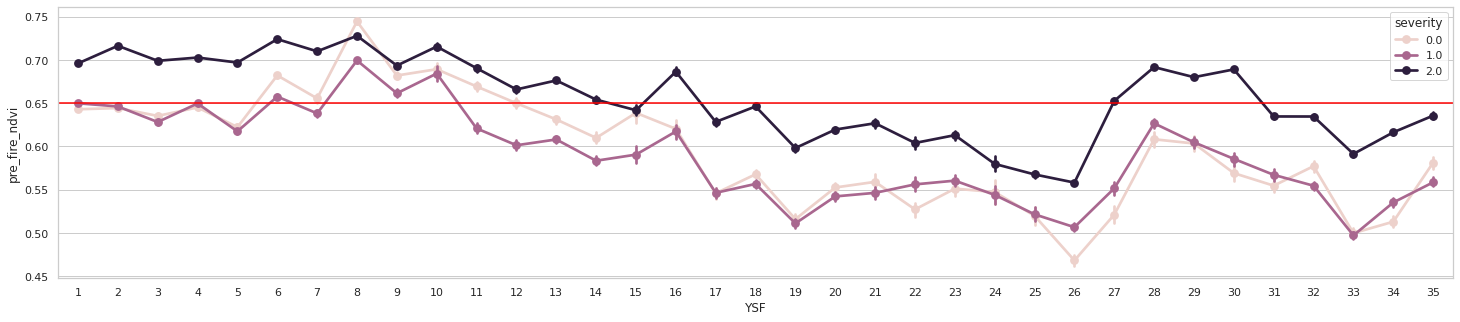

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="pre_fire_ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

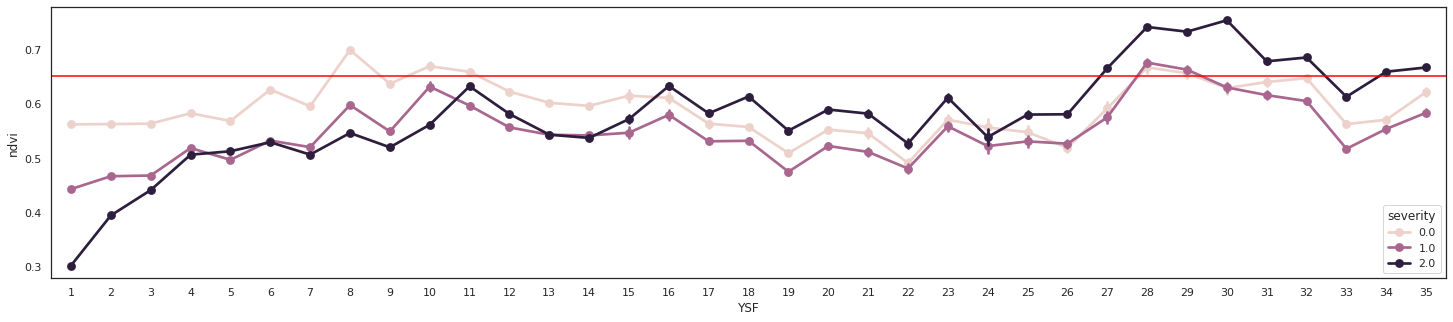

In [26]:
 fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

<AxesSubplot: xlabel='YSF', ylabel='ndvi_ratio'>

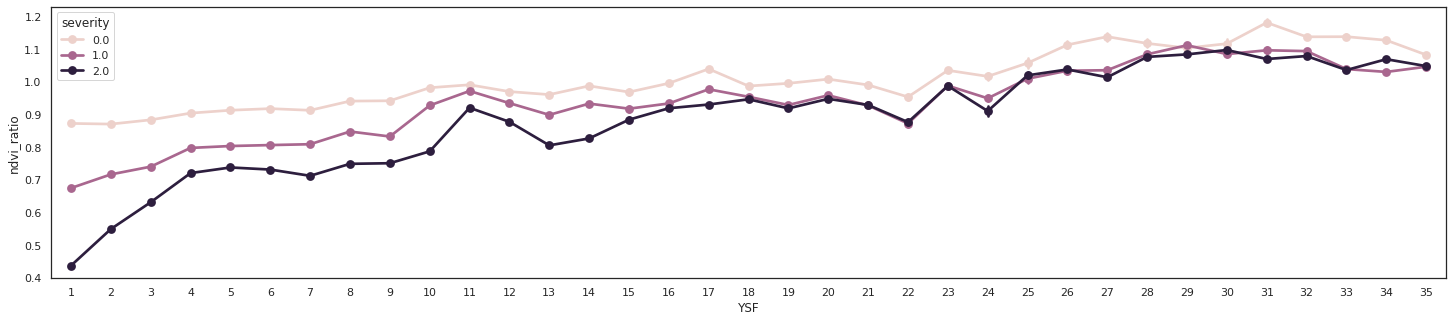

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF", y="ndvi_ratio", ax=ax, hue="severity")

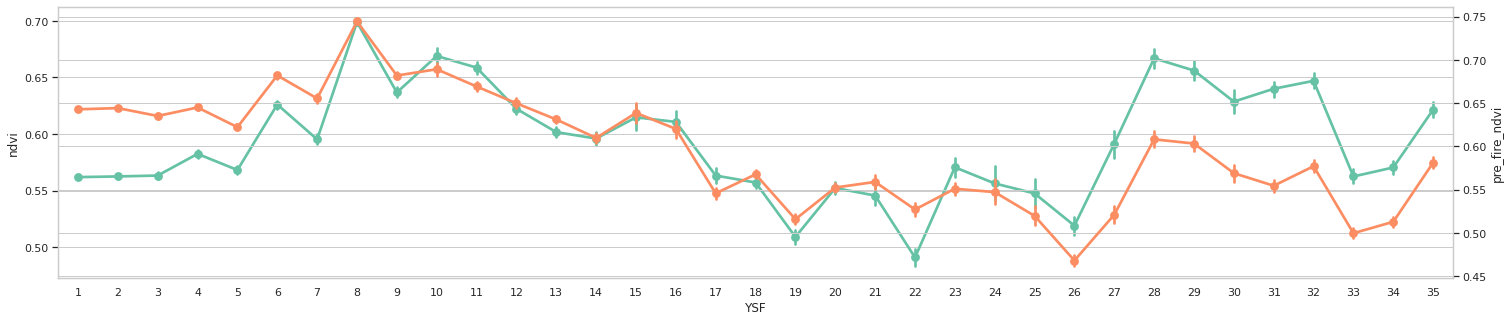

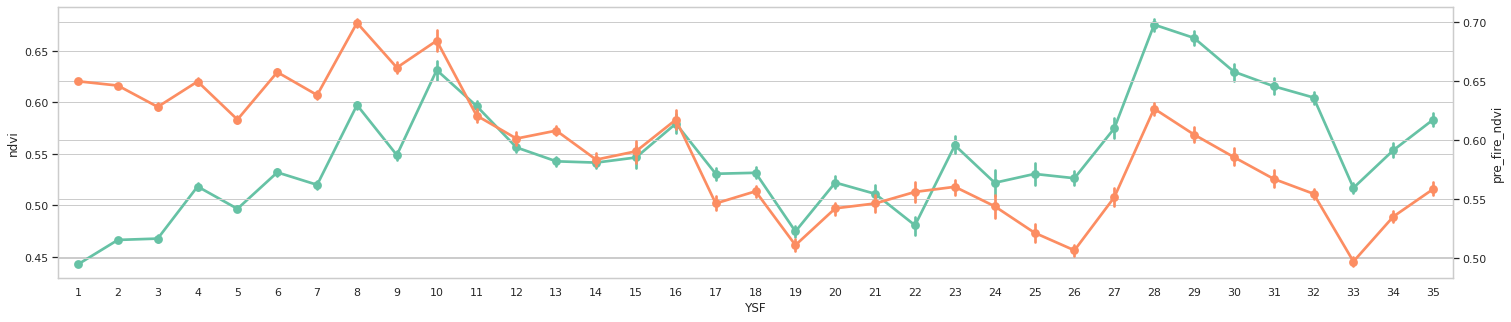

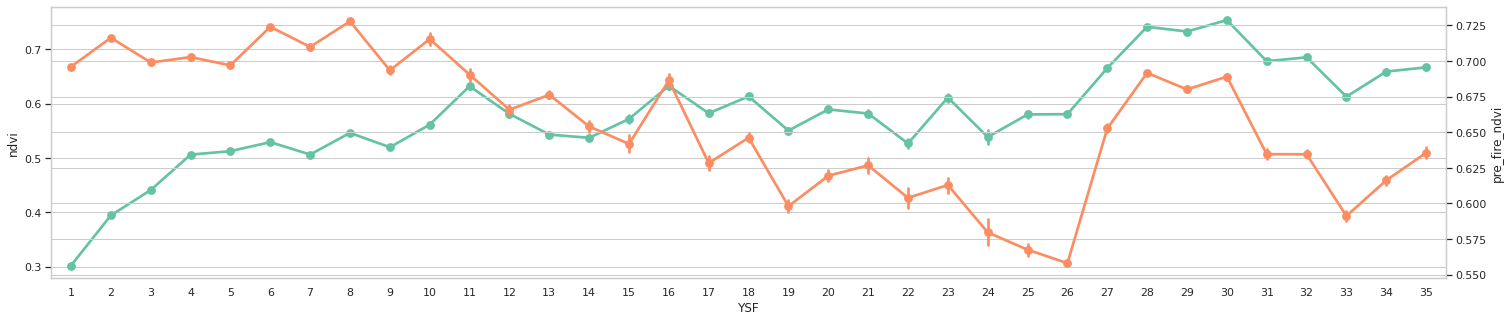

In [30]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="ndvi", ax=ax)
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1])

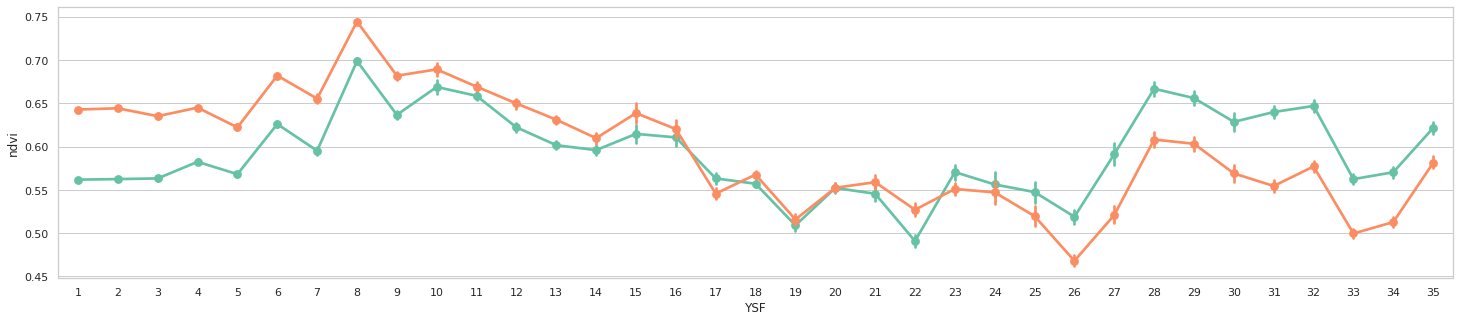

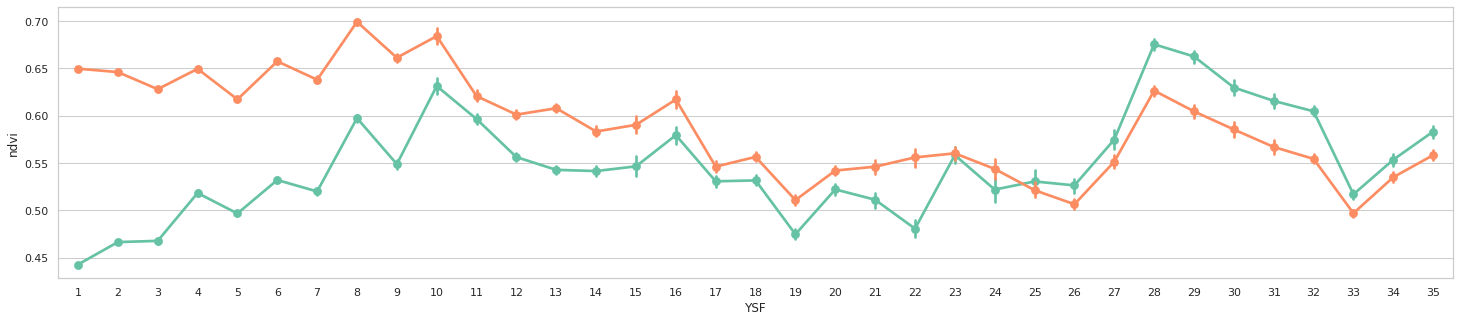

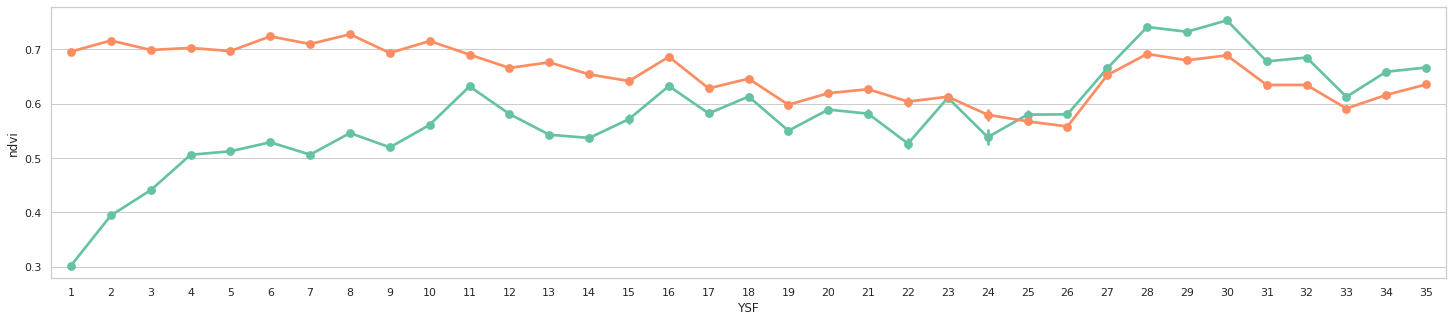

In [31]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="ndvi", ax=ax)
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax, color=palette[1])

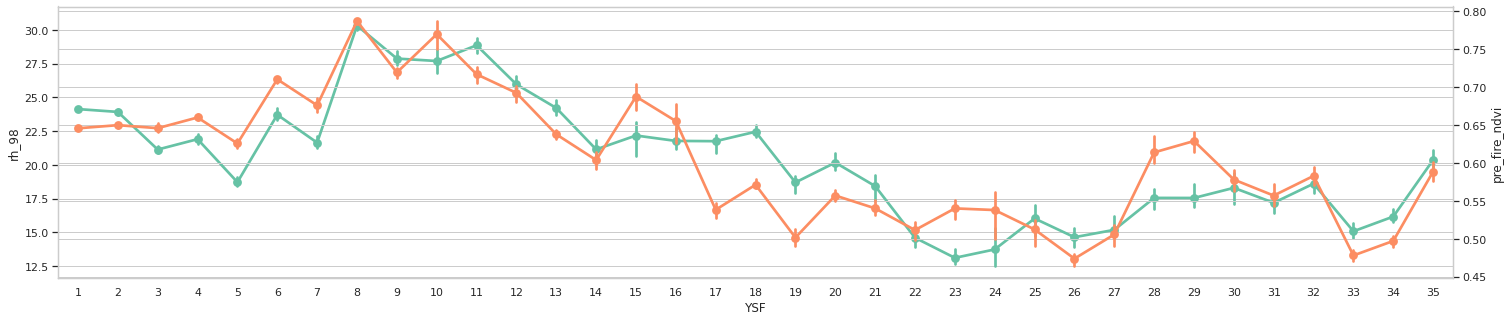

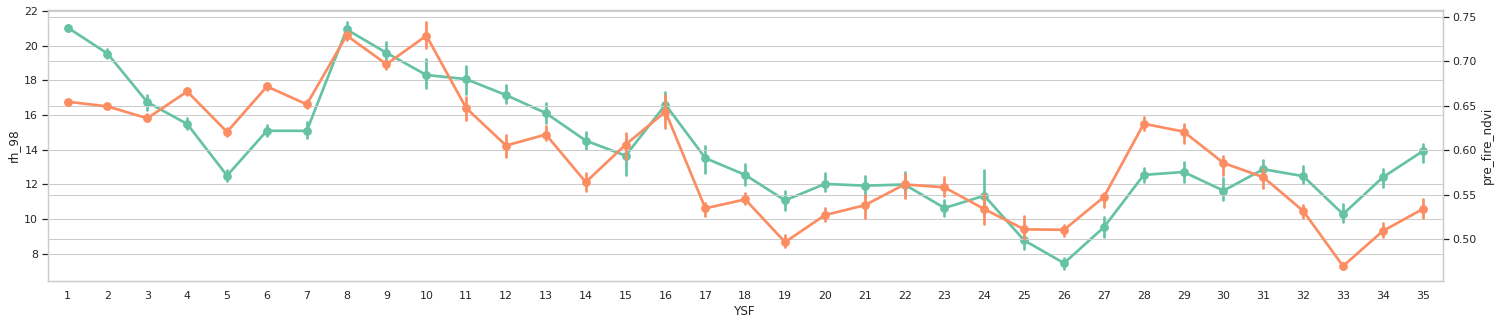

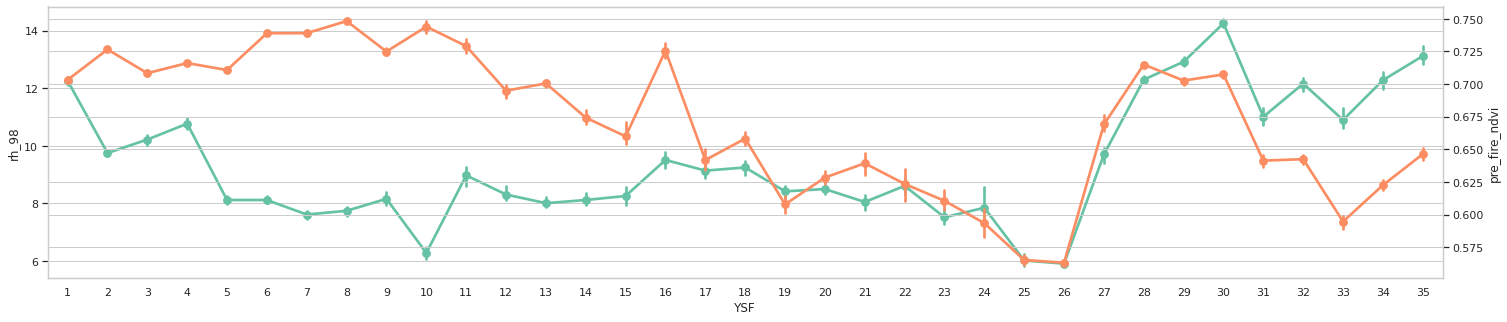

In [32]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF", y="rh_98", ax=ax, estimator="median")
    sns.pointplot(dft, x="YSF", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

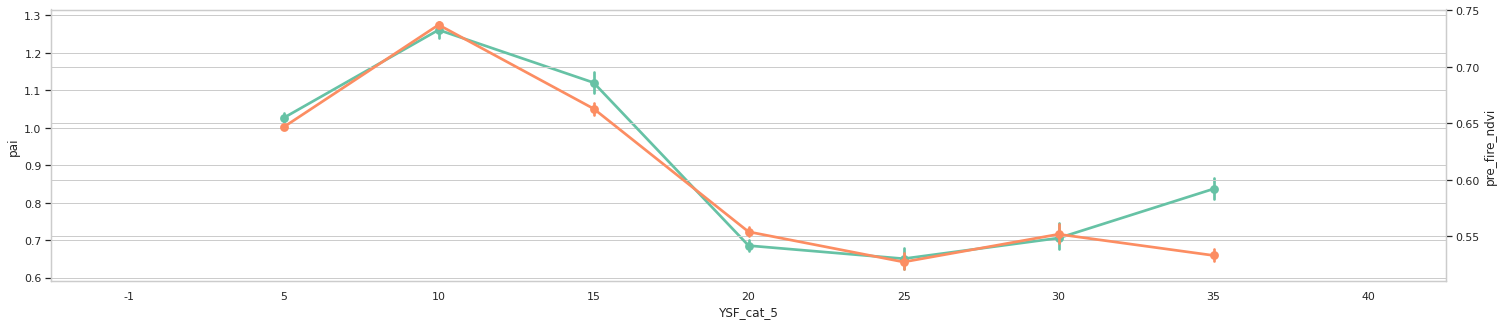

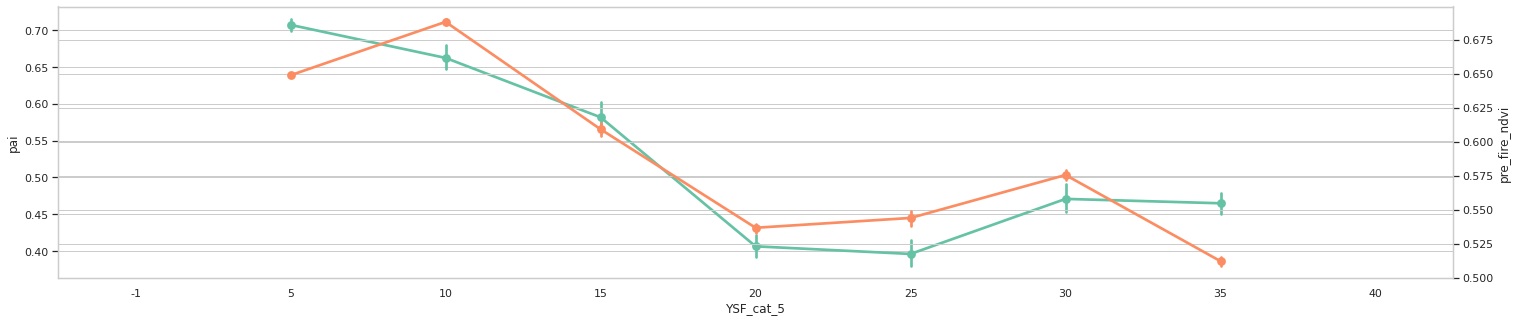

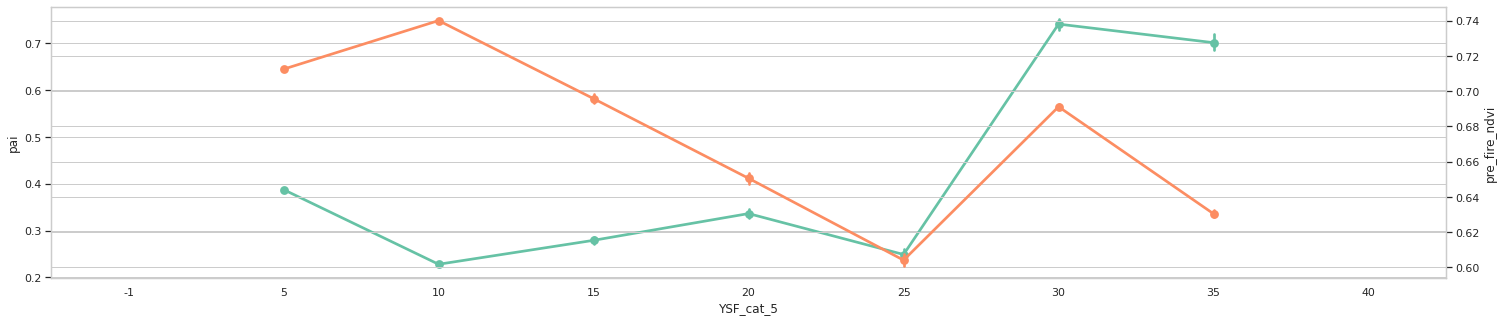

In [33]:
for severity in range(0, 3):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax2 = ax.twinx()
    dft = burned[burned.severity == severity]
    sns.pointplot(dft, x="YSF_cat_5", y="pai", ax=ax, estimator="median")
    sns.pointplot(dft, x="YSF_cat_5", y="pre_fire_ndvi", ax=ax2, color=palette[1], estimator="median")

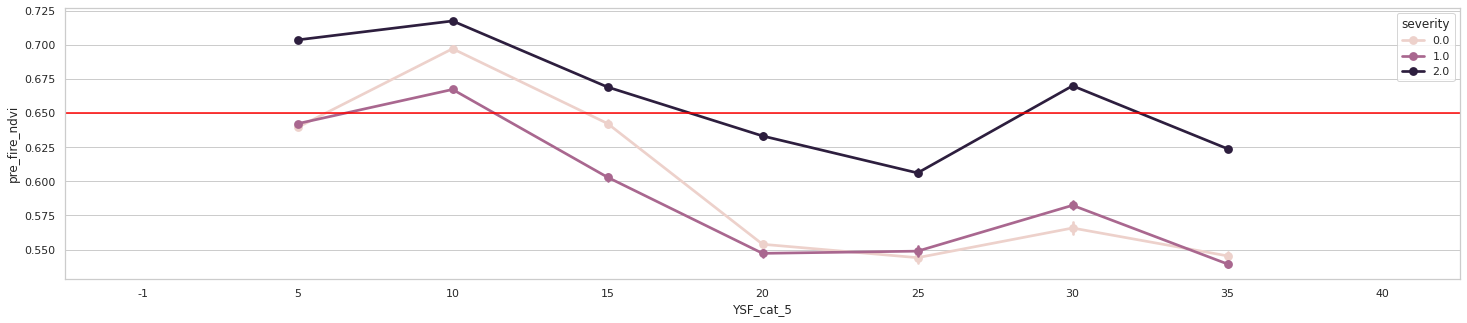

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="pre_fire_ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

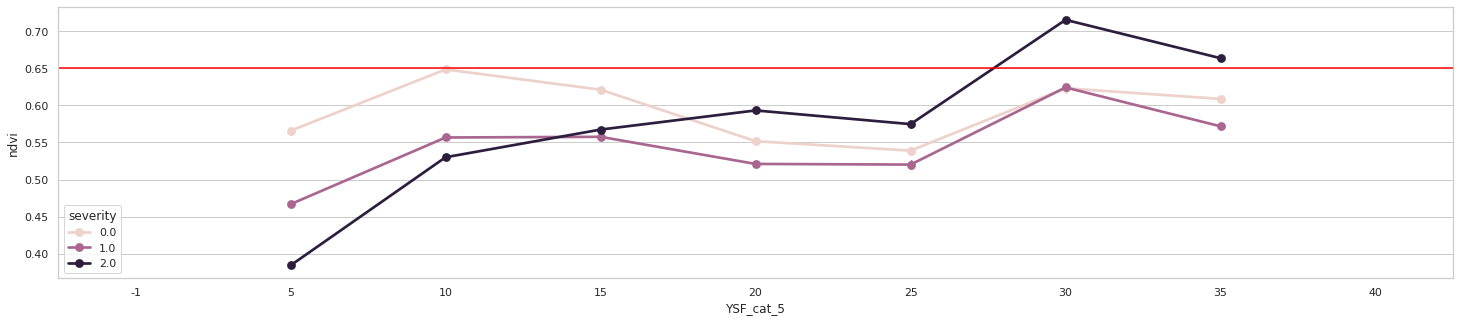

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="ndvi", ax=ax, hue="severity")
ax.axhline(unburned.ndvi.mean(), color="red")

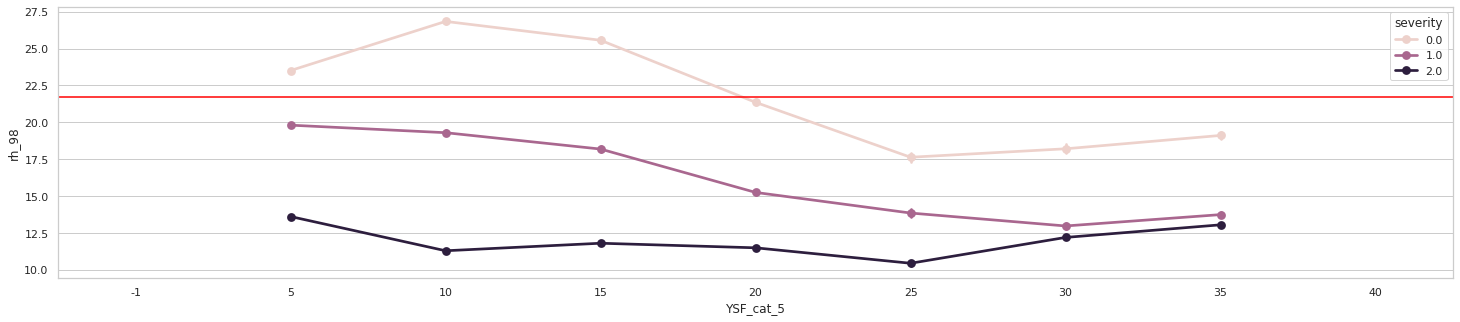

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="rh_98", ax=ax, hue="severity")
ax.axhline(unburned.rh_98.mean(), color="red")

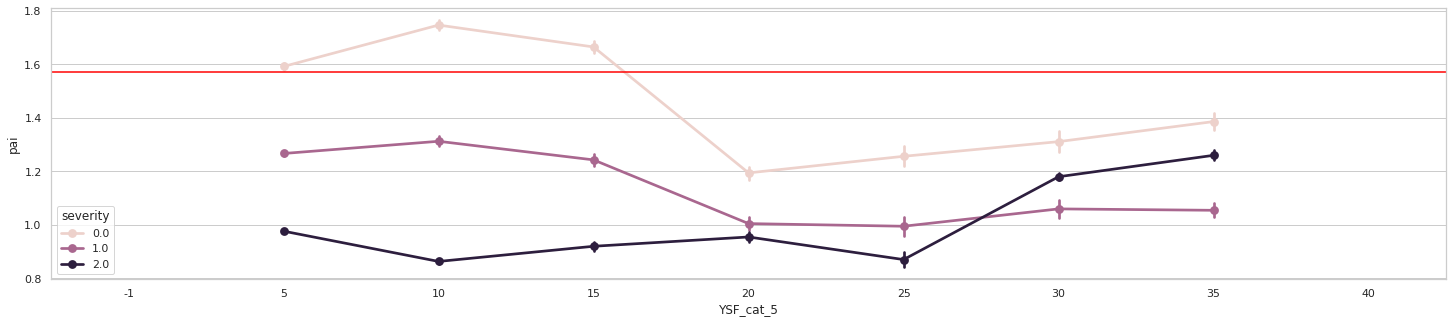

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(burned, x="YSF_cat_5", y="pai", ax=ax, hue="severity")
ax.axhline(unburned.pai.mean(), color="red")

In [38]:
low_c = sns.color_palette("rocket")[5]
mod_c = sns.color_palette("rocket")[3]
high_c = sns.color_palette("rocket")[0]

In [39]:
def kde_severity(data_frame, metric, severity, ax):
    dft = data_frame[data_frame.severity == severity]
    if severity == 0:
        color = low_c
    elif severity == 1:
        color = mod_c
    else:
        color = high_c
    sns.kdeplot(dft, x=metric, ax=ax, color=color)


In [40]:
def kde_before_after(metric, before, after):
    fig, ax = plt.subplots(1, 2, figsize=(25, 7))
    sns.kdeplot(unburned, x=metric, ax=ax[0], color="gray", linestyle="--")
    sns.kdeplot(unburned, x=metric, ax=ax[1], color="gray", linestyle="--")

    dft = burned[burned.YSF_cat_5 == before]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[0])


    dft = burned[burned.YSF_cat_5 == after]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[1])


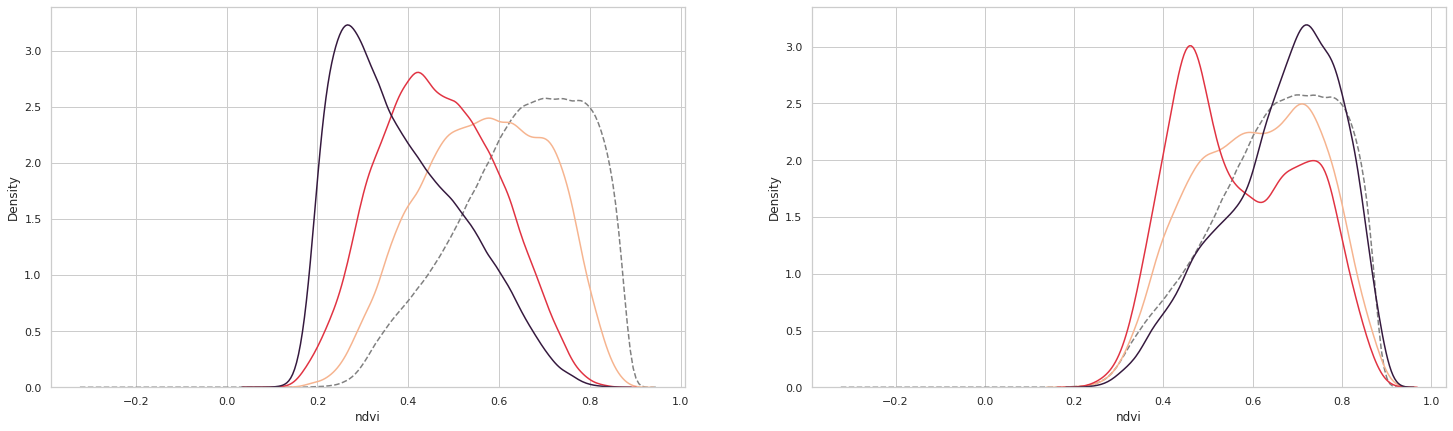

In [41]:
kde_before_after("ndvi", 5, 35)

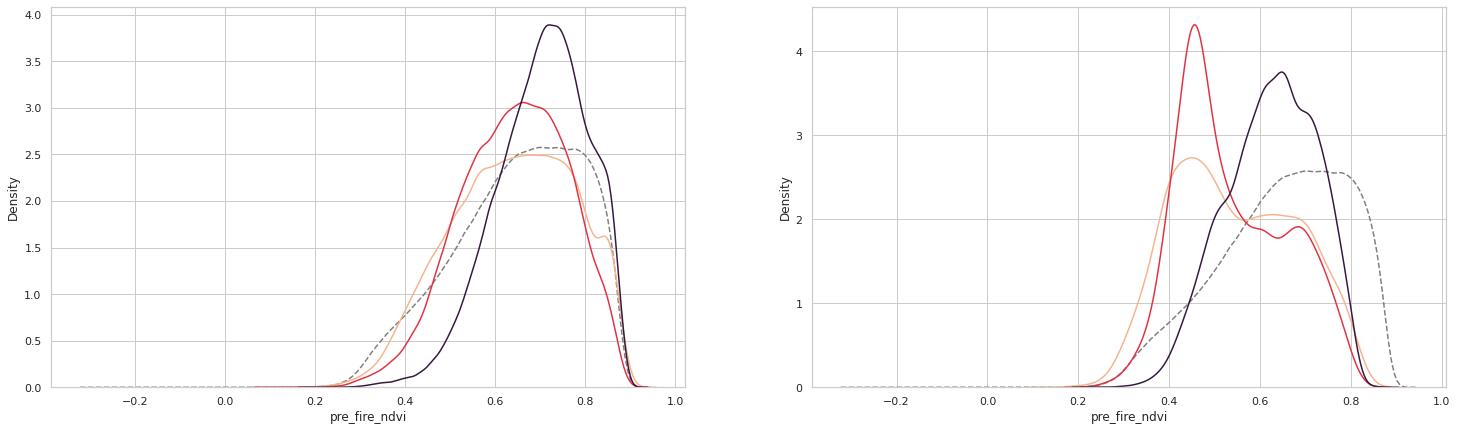

In [42]:
kde_before_after("pre_fire_ndvi", 5, 35)

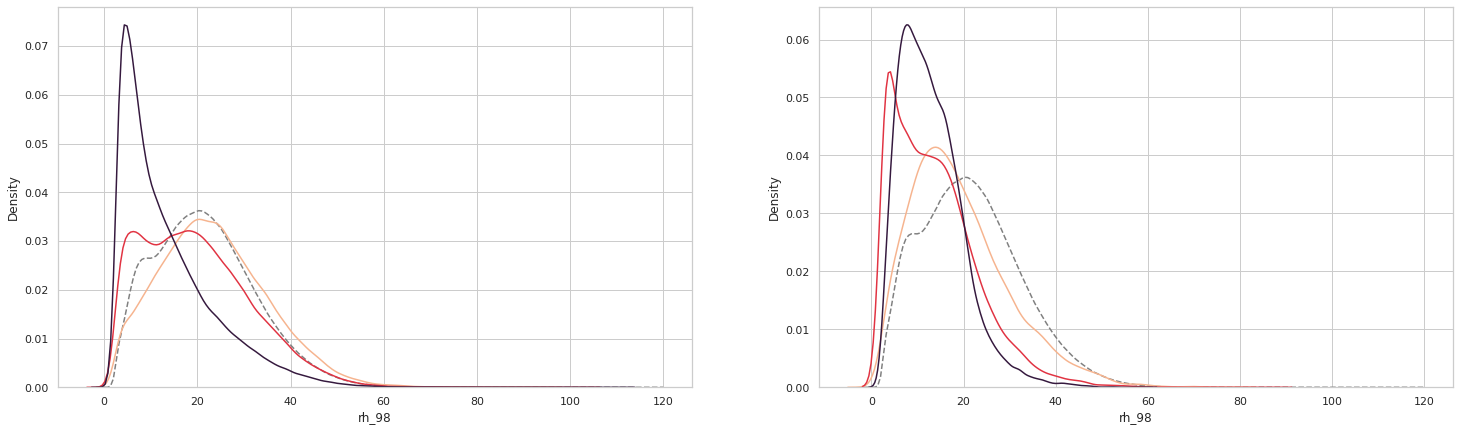

In [43]:
kde_before_after("rh_98", 5, 35)

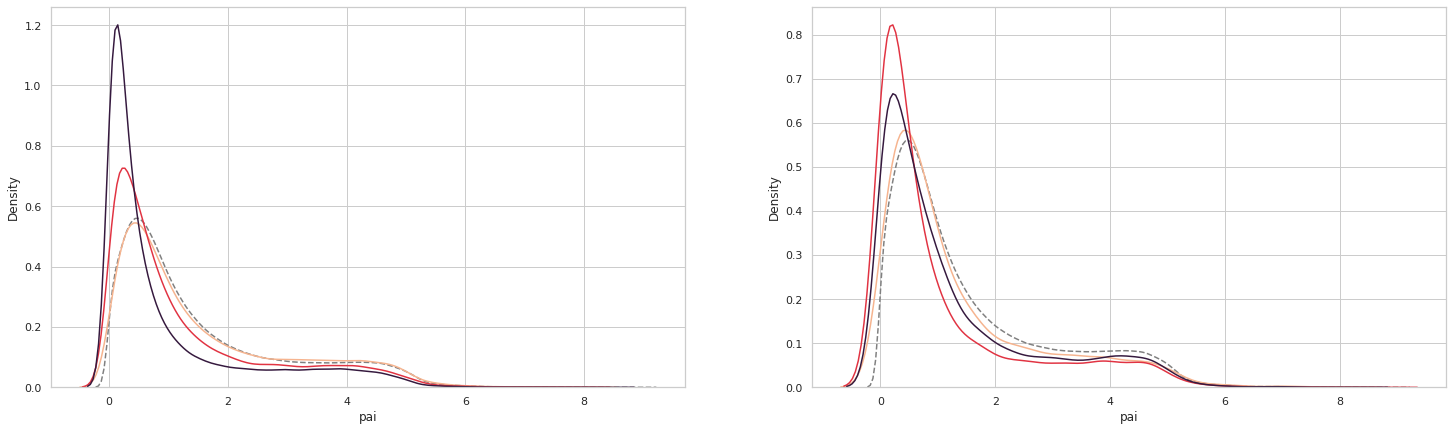

In [44]:
kde_before_after("pai", 5, 35)

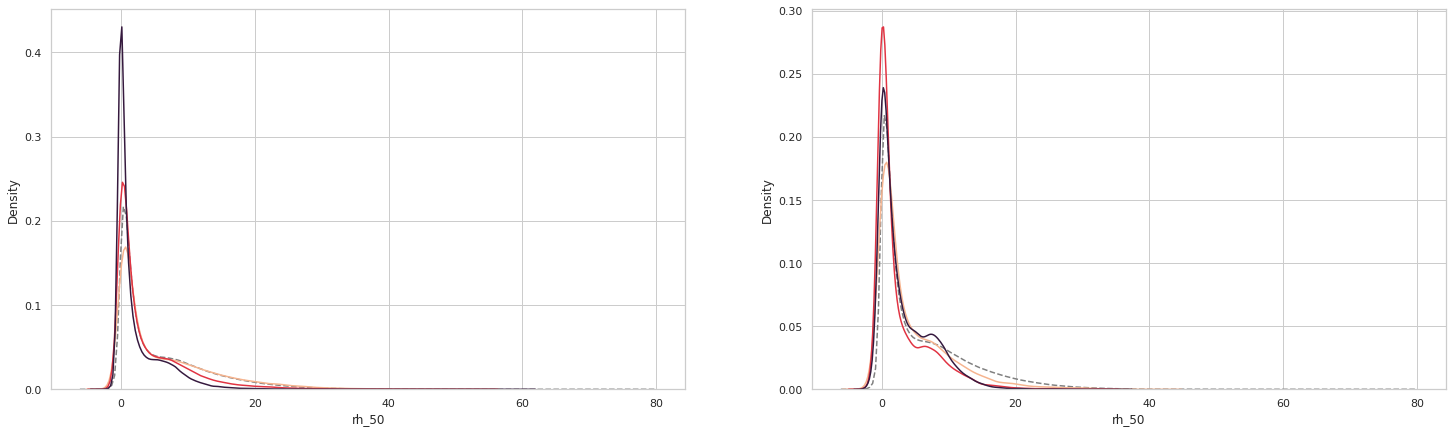

In [45]:
kde_before_after("rh_50", 5, 35)

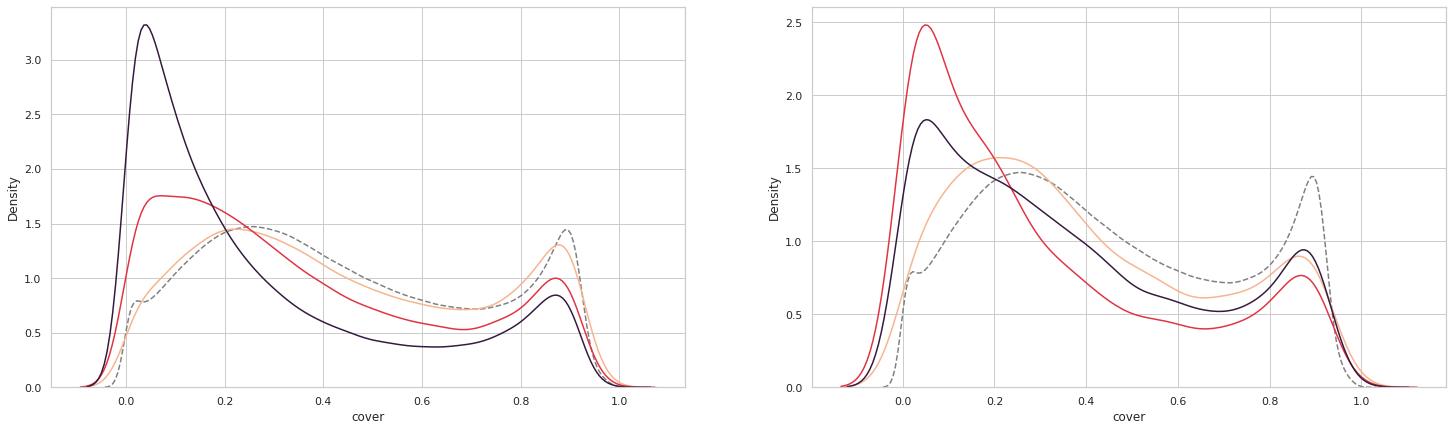

In [46]:
kde_before_after("cover", 5, 35)

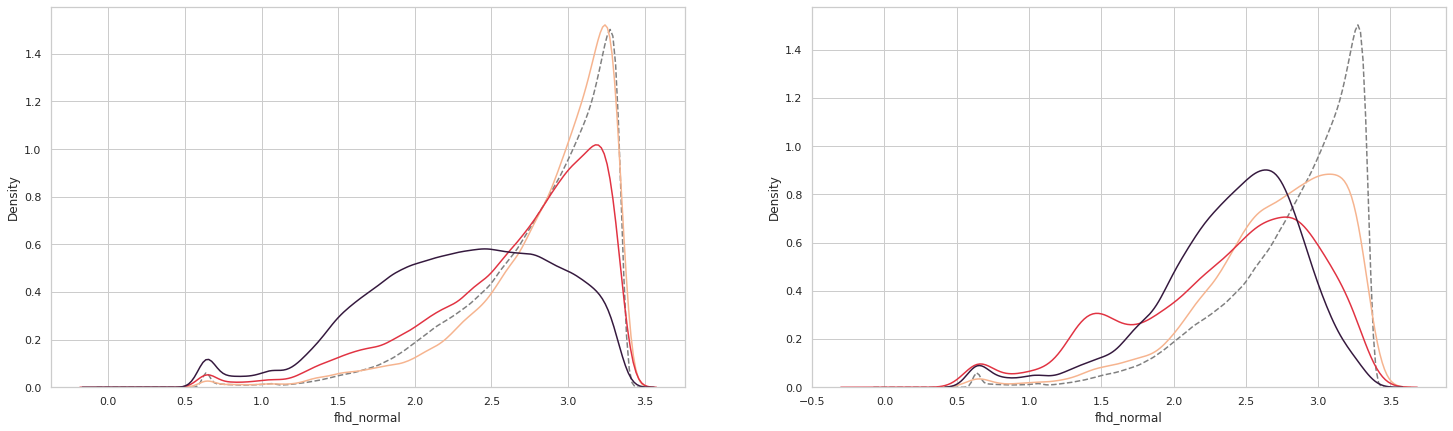

In [47]:
kde_before_after("fhd_normal", 5, 35)

In [48]:
columns = [
 'fire_size_acres',
 'pre_fire_ndvi',
 'YSF',
 'YSF_cat_5',
 'agbd',
 'cover',
 'fhd_normal',
 'latitude',
 'longitude',
 'pai',
 'rh_25',
 'rh_50',
 'rh_70',
 'rh_98',
 'aspect',
 'elevation',
 'slope',
 'soil',
 'ndvi',
 'cover']

In [49]:
# look at high-severity only
correlations_burned = burned[burned.severity ==0][columns + ["ndvi_ratio"]].corr()
correlations_unburned = unburned[columns].corr()
correlations_burned.pre_fire_ndvi

fire_size_acres    0.058880
pre_fire_ndvi      1.000000
YSF               -0.238063
YSF_cat_5         -0.236087
agbd               0.519482
cover              0.509780
fhd_normal         0.467310
latitude           0.111119
longitude         -0.251198
pai                0.440011
rh_25              0.453552
rh_50              0.552159
rh_70              0.592042
rh_98              0.562375
aspect             0.027229
elevation         -0.222795
slope              0.189991
soil              -0.179490
ndvi               0.860547
cover              0.509780
ndvi_ratio        -0.207618
Name: pre_fire_ndvi, dtype: float64

In [50]:
# look at high-severity only
correlations_burned = burned[burned.severity == 2][columns + ["ndvi_ratio"]].corr()
correlations_unburned = unburned[columns].corr()

In [51]:
correlations_burned.pre_fire_ndvi, correlations_unburned.pre_fire_ndvi

(fire_size_acres    0.091888
 pre_fire_ndvi      1.000000
 YSF               -0.219323
 YSF_cat_5         -0.220304
 agbd               0.247508
 cover              0.238200
 fhd_normal         0.260534
 latitude           0.175334
 longitude         -0.337003
 pai                0.199402
 rh_25              0.196881
 rh_50              0.235378
 rh_70              0.259768
 rh_98              0.282647
 aspect             0.043073
 elevation         -0.305529
 slope              0.113290
 soil              -0.209932
 ndvi               0.303433
 cover              0.238200
 ndvi_ratio        -0.164292
 Name: pre_fire_ndvi, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      1.000000
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.504748
 cover              0.510414
 fhd_normal         0.491942
 latitude           0.225472
 longitude         -0.473207
 pai                0.439823
 rh_25              0.455620
 rh_50              0.537785
 rh_7

In [52]:
correlations_burned.ndvi_ratio

fire_size_acres   -0.529192
pre_fire_ndvi     -0.164292
YSF                0.783844
YSF_cat_5          0.761270
agbd               0.036099
cover              0.099192
fhd_normal         0.075635
latitude           0.075018
longitude         -0.126794
pai                0.079272
rh_25              0.060443
rh_50              0.103045
rh_70              0.096784
rh_98              0.018899
aspect             0.032319
elevation         -0.210003
slope             -0.020345
soil               0.065155
ndvi               0.878260
cover              0.099192
ndvi_ratio         1.000000
Name: ndvi_ratio, dtype: float64

In [53]:
correlations_burned.rh_70, correlations_unburned.rh_70

(fire_size_acres   -0.021176
 pre_fire_ndvi      0.259768
 YSF                0.050851
 YSF_cat_5          0.054223
 agbd               0.912225
 cover              0.807220
 fhd_normal         0.624649
 latitude          -0.021454
 longitude         -0.052536
 pai                0.767829
 rh_25              0.784500
 rh_50              0.915119
 rh_70              1.000000
 rh_98              0.778182
 aspect             0.019109
 elevation         -0.135312
 slope              0.276536
 soil              -0.025881
 ndvi               0.218052
 cover              0.807220
 ndvi_ratio         0.096784
 Name: rh_70, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.566889
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.949480
 cover              0.783898
 fhd_normal         0.620224
 latitude           0.065974
 longitude         -0.210235
 pai                0.721120
 rh_25              0.755877
 rh_50              0.917507
 rh_70       

In [54]:
correlations_burned.pai, correlations_unburned.pai

(fire_size_acres   -0.027044
 pre_fire_ndvi      0.199402
 YSF                0.058148
 YSF_cat_5          0.059457
 agbd               0.590318
 cover              0.959306
 fhd_normal         0.493692
 latitude          -0.022383
 longitude         -0.049675
 pai                1.000000
 rh_25              0.956312
 rh_50              0.884614
 rh_70              0.767829
 rh_98              0.541322
 aspect             0.023540
 elevation         -0.151336
 slope              0.278075
 soil              -0.035748
 ndvi               0.173538
 cover              0.959306
 ndvi_ratio         0.079272
 Name: pai, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.439823
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.623365
 cover              0.950757
 fhd_normal         0.398821
 latitude           0.024572
 longitude         -0.166658
 pai                1.000000
 rh_25              0.890874
 rh_50              0.801628
 rh_70         

In [55]:
correlations_burned.YSF, correlations_burned.YSF_cat_5

(fire_size_acres   -0.435517
 pre_fire_ndvi     -0.219323
 YSF                1.000000
 YSF_cat_5          0.992373
 agbd              -0.025270
 cover              0.078532
 fhd_normal         0.017669
 latitude           0.170755
 longitude         -0.199344
 pai                0.058148
 rh_25              0.042322
 rh_50              0.068736
 rh_70              0.050851
 rh_98             -0.054887
 aspect             0.034005
 elevation         -0.180832
 slope             -0.087225
 soil               0.101514
 ndvi               0.640430
 cover              0.078532
 ndvi_ratio         0.783844
 Name: YSF, dtype: float64,
 fire_size_acres   -0.403630
 pre_fire_ndvi     -0.220304
 YSF                0.992373
 YSF_cat_5          1.000000
 agbd              -0.021309
 cover              0.081018
 fhd_normal         0.022199
 latitude           0.171247
 longitude         -0.194417
 pai                0.059457
 rh_25              0.044321
 rh_50              0.070293
 rh_70         

In [56]:
dfp = burned[burned.severity == 2]

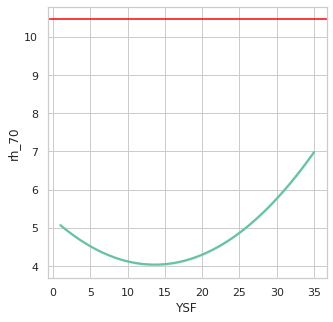

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

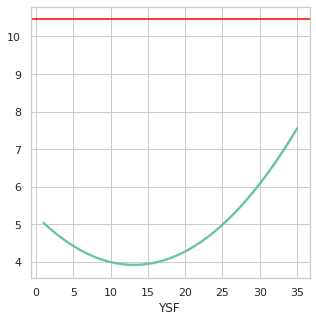

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

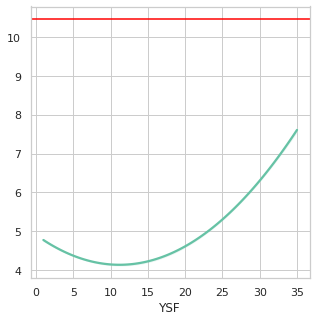

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

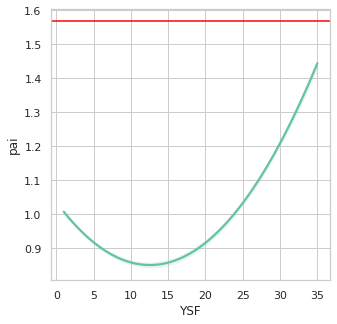

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, order=2)
ax.axhline(unburned.pai.mean(), color="red")

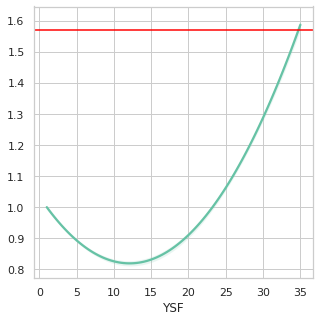

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.pai.mean(), color="red")

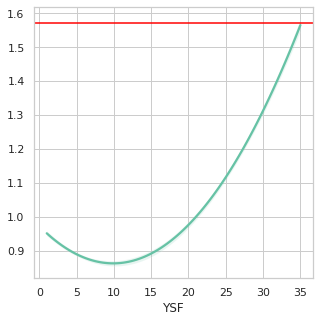

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.pai.mean(), color="red")

In [63]:
dfp = burned[burned.severity == 0]

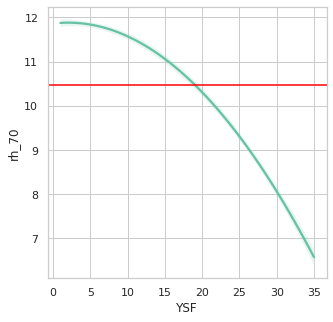

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

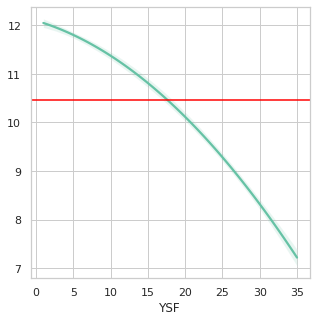

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

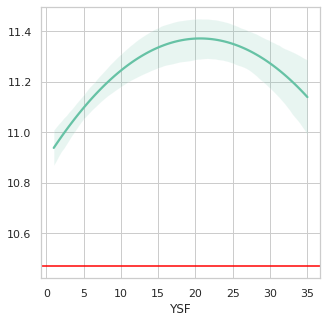

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.rh_70.mean(), color="red")

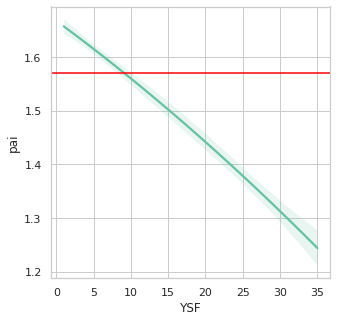

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, order=2)
ax.axhline(unburned.pai.mean(), color="red")

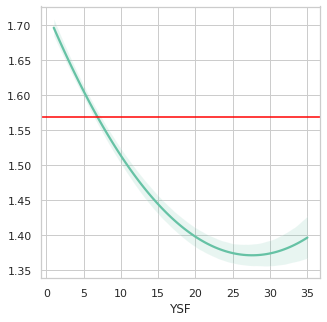

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="slope", order=2)
ax.axhline(unburned.pai.mean(), color="red")

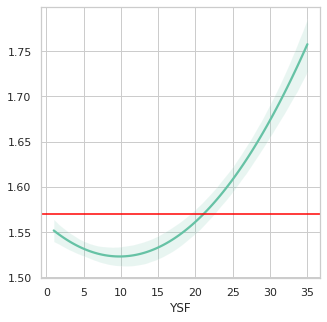

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(unburned.pai.mean(), color="red")